# Application Project
## Store Sales - Time Series Forecasting
### Using statistical methods (SARIMAX) to predict grocery sales

In [249]:
import numpy as np
import seaborn as sb
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

## File Descriptions and Data Field Information

#### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

#### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### transactions.csv
- Number of transactions per day

### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

## Visualisation of each datasets

In [250]:
train = pd.read_csv('train.csv')
train

#TODO can visualize by comparing different family & store number with sales.
#1st group up data with same dates and sum up the sales.

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [251]:
oil = pd.read_csv('oil.csv')
oil.head()
#simple comparison

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [252]:
transactions = pd.read_csv('transactions.csv')
transactions

#compare sales to transactions. Note it is separated by different store numbers. Can compare each individually or also sum up total transactions per day
# also get correlation number. If high, can use multicollinearity

#check for any missing data for each store number by visualising

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


## Exploratory Data Analysis and Feature Engineering

#### For this project, we will only focus on 1 store, store 44. This store has the highest number of sales as compared to other stores from 2013 to 2017

In [253]:
#Only retaining data from store 44
nTrain = train[train['store_nbr'] == 44].copy()

#changing dtype of 'date' to datetime
nTrain['date'] = pd.to_datetime(nTrain['date'])

#creating columns by extracting the day, month, year
nTrain['year'] = nTrain['date'].dt.year
nTrain['month'] = nTrain['date'].dt.month
nTrain['day'] = nTrain['date'].dt.day
nTrain

,id,date,store_nbr,family,sales,onpromotion,year,month,day
1254,1254,2013-01-01,44,AUTOMOTIVE,0.000,0,2013,1,1
1255,1255,2013-01-01,44,BABY CARE,0.000,0,2013,1,1
1256,1256,2013-01-01,44,BEAUTY,0.000,0,2013,1,1
1257,1257,2013-01-01,44,BEVERAGES,0.000,0,2013,1,1
1258,1258,2013-01-01,44,BOOKS,0.000,0,2013,1,1
...,...,...,...,...,...,...,...,...,...
3000388,3000388,2017-08-15,44,POULTRY,909.194,0,2017,8,15
3000389,3000389,2017-08-15,44,PREPARED FOODS,329.522,0,2017,8,15
3000390,3000390,2017-08-15,44,PRODUCE,7239.617,10,2017,8,15
3000391,3000391,2017-08-15,44,SCHOOL AND OFFICE SUPPLIES,345.000,12,2017,8,15


In [254]:
# Find the number of unique categories under 'family'
num_unique_categories = nTrain['family'].nunique()

# Print the results
print("Number of Unique Categories under 'family':", num_unique_categories)

Number of Unique Categories under 'family': 33


### Sales data

In [255]:
#Summing up sales per day
salesPerDay_train = nTrain.groupby('date')['sales'].sum().reset_index()
salesPerDay_train

,date,sales
0,2013-01-01,0.000000
1,2013-01-02,30095.181000
2,2013-01-03,20447.057000
3,2013-01-04,22795.799000
4,2013-01-05,31382.508000
...,...,...
1679,2017-08-11,43330.500000
1680,2017-08-12,41559.973000
1681,2017-08-13,45604.445000
1682,2017-08-14,35617.528004


##### As seen below, there seems to be a gradual upward trend of total sales. All the first days of the year have 0 sales, and this may be related to the store being closed due to end of year events.

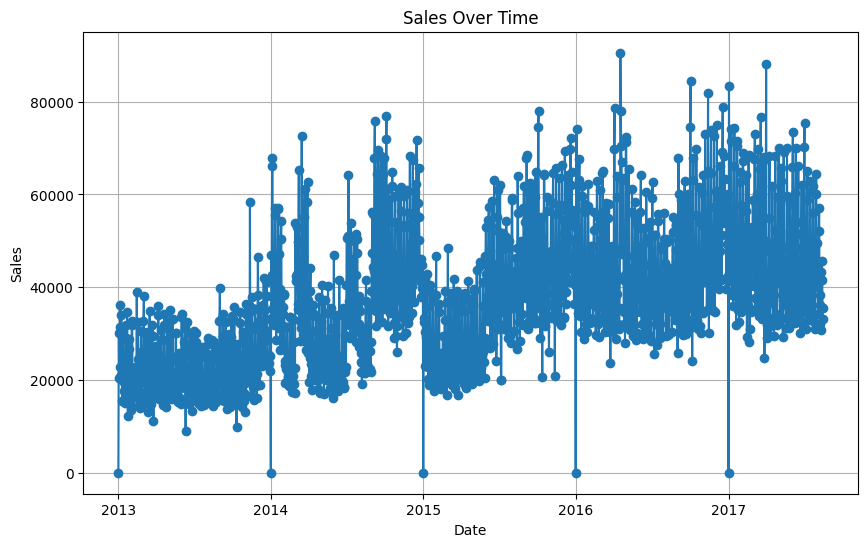

In [256]:
plt.figure(figsize=(10, 6))
plt.plot(salesPerDay_train['date'], salesPerDay_train['sales'], marker='o', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### Transactions data

In [257]:
#Only retaining transactions data from store 44
nTransactions = transactions[transactions['store_nbr'] == 44].copy()

#changing dtype of 'date' to datetime
nTransactions['date'] = pd.to_datetime(nTransactions['date'])

#### From the plotted graph below, we can see some seasonality trends/ patterns recurring every year. A spike in transactions at the end of every year can be observed. Another graph can be plotted to better visualise the number of transactions per month, using box-plot 

In [258]:
px.line(nTransactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

#### The box plots gives us a better view of the spike in transactions. This occurs in December. Probably due to Christmas and New Years holidays

In [259]:
a = nTransactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")

#### When we look at the relationship between total sales and transactions, we can see that there is a high correlation via a scatterplot

In [260]:
#Checking correlation between total sales and transactions  
temp = pd.merge(nTrain.groupby(["date", "store_nbr"]).sales.sum().reset_index(), nTransactions, how = "left")

px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")


#### With a relatively high correlation to total sales, transactions can be used as an exogenous variable

In [261]:
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))

Spearman Correlation between Total Sales and Transactions: 0.6883


### OIL PRICES

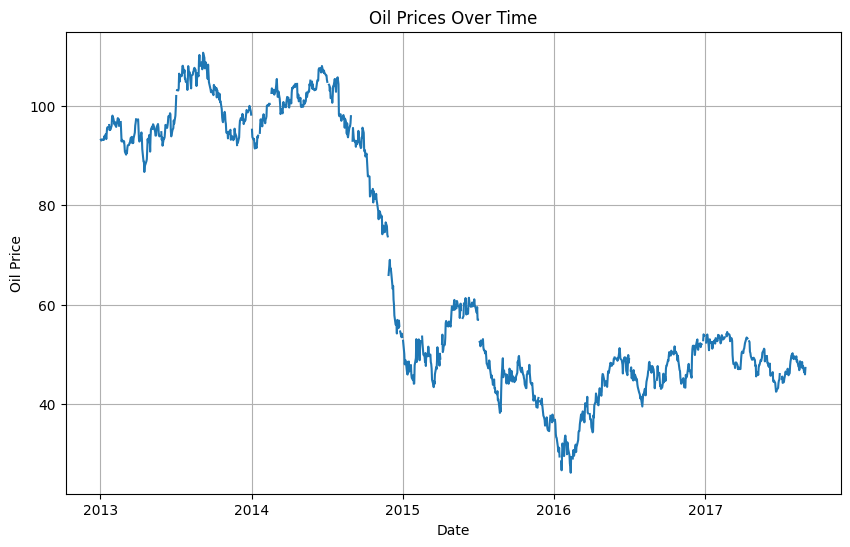

In [262]:
oil["date"] = pd.to_datetime(oil.date)

plt.figure(figsize=(10, 6))
plt.plot(oil['date'], oil['dcoilwtico'], linestyle='-')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.grid(True)
plt.show()

#### Since some datapoints are missing from the original oil dataset, we can utilise linear interpolation to fill in missing data (it assumes a linear relationship between the two neighbouring data points, ie. connecting the dots)

In [263]:
# Setting date as index, resampling with "D" (Daily) as argument
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()

# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()

# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

#### Logically, if the daily oil price is high, we expect that Ecuador's economy is bad and it means the price of product increases and sales decreases. There is a negative relationship here. This is further corroborated by 2 visible clusters within the scatterplot, with $70 as a 'border' between the 2 clusters. The Spearman correlation also demonstrates a fairly acceptable value of -0.495. Oil prices can also be a consideration as an exogenous variable

Total Sales for Oil Prices Below 70: 42035942.19
Total Sales for Oil Prices Above or Equal to 70: 20051611.06
Correlation with Daily Oil Prices
sales          -0.495486
transactions   -0.091714
Name: dcoilwtico_interpolated, dtype: float64 



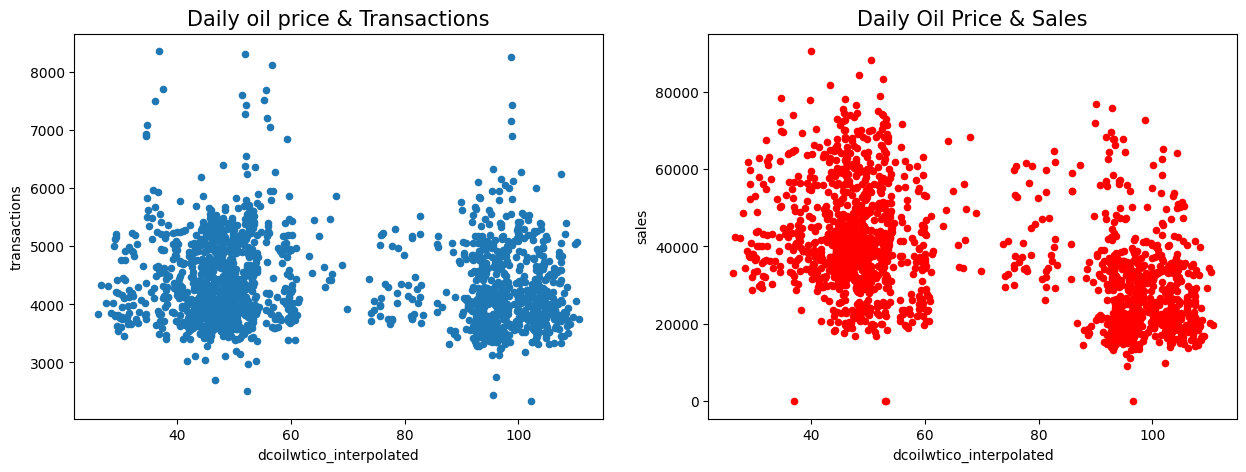

In [264]:
# Merge 'temp' and 'oil' DataFrames
temp = pd.merge(temp, oil, how="left")

# Calculate the total sales for oil prices below 70
total_sales_below_70 = temp[temp['dcoilwtico_interpolated'] < 70]['sales'].sum()

# Calculate the total sales for oil prices above or equal to 70
total_sales_above_70 = temp[temp['dcoilwtico_interpolated'] >= 70]['sales'].sum()

# Print the total sales for both categories
print("Total Sales for Oil Prices Below 70: {:.2f}".format(total_sales_below_70))
print("Total Sales for Oil Prices Above or Equal to 70: {:.2f}".format(total_sales_above_70))

# Print correlation with daily oil prices
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis=1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
temp.plot.scatter(x="dcoilwtico_interpolated", y="transactions", ax=axes[0])
temp.plot.scatter(x="dcoilwtico_interpolated", y="sales", ax=axes[1], color="r")
axes[0].set_title('Daily oil price & Transactions', fontsize=15)
axes[1].set_title('Daily Oil Price & Sales', fontsize=15)

# Show the plots
plt.show()

In [265]:
print("Spearman Correlation between 'onpromotion' and 'sales': {:.4f}".format(nTrain[['onpromotion', 'sales']].corr(method='spearman').iloc[0, 1]))

Spearman Correlation between 'onpromotion' and 'sales': 0.5229


#### We also aim to find out if pay days, which are on the 1st and 15th of each month, affects sales on those particular days. 'isPayday' and 'sales' does not seem to have a strong correlation, based on the spearman correlation.

In [266]:
nTrain['isPayday'] = ((nTrain['date'].dt.day == 1) | (nTrain['date'].dt.day == 15)).astype(int)
print("Spearman Correlation between 'isPayday' and 'sales': {:.4f}".format(nTrain[['isPayday', 'sales']].corr(method='spearman').iloc[0, 1]))

Spearman Correlation between 'isPayday' and 'sales': -0.0103


## SARIMAX

##### For this project, we are focusing on Autoregressive Integrated Moving Average (ARIMA) models and their extension, Seasonal AutoRegressive Integrated Moving Average with eXogenous factors (SARIMAX).

##### ARIMA is a widely-used model for time series forecasting that combines autoregression (AR), differencing (I), and moving average (MA) components. The AR term captures the linear dependence of the current value on its past values, the differencing term addresses non-stationarity, and the MA term deals with the dependency between a residual error and its lagged values.

##### Since our dataset has seasonality trends, we will use SARIMAX

### Stationarity Check, via the Augmented Dickey-Fuller test

In [267]:
# Stationary test
result = adfuller(nTrain['sales'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -22.583424544536705
p-value: 0.0
Critical Values: {'1%': -3.430467805202674, '5%': -2.86159206759412, '10%': -2.5667977138384797}


In [268]:
tseries1 = nTrain.groupby(['date'])['sales'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'sales'})

### Model Fitting

#### We would be trying 3 different iterations of the model

##### 1. Without any exogenous variables
##### 2. With all exogenous variables
##### 3. With all exogenous variables except for IsPayday



##### Model 1 - Without exogenous variables

Predicted Values:
 1668    58172.246417
1669    54945.668371
1670    58777.641854
1671    47624.643273
1672    45605.431419
1673    41612.854365
1674    33338.483828
1675    41730.744118
1676    48789.090979
1677    54501.519669
1678    50705.885666
1679    47628.647662
1680    50088.098351
1681    42600.871267
1682    49326.772656
1683    52942.935785
Name: predicted_mean, dtype: float64

Confidence Intervals:
        lower sales    upper sales
1668  17271.787830   99072.705004
1669  10188.210373   99703.126369
1670  13291.695502  104263.588206
1671   1992.717068   93256.569478
1672    -57.062048   91267.924887
1673  -4056.552697   87282.261427
1674 -12332.730819   79009.698474
1675  -3941.069927   87402.558163
1676   3117.005950   94461.176007
1677   8829.268554  100173.770783
1678   5033.506969   96378.264362
1679   1956.156879   93301.138445
1680   1427.532043   98748.664658
1681  -6636.682862   91838.425396
1682    -28.508015   98682.053327
1683   3562.169831  102323.701739

Mean 

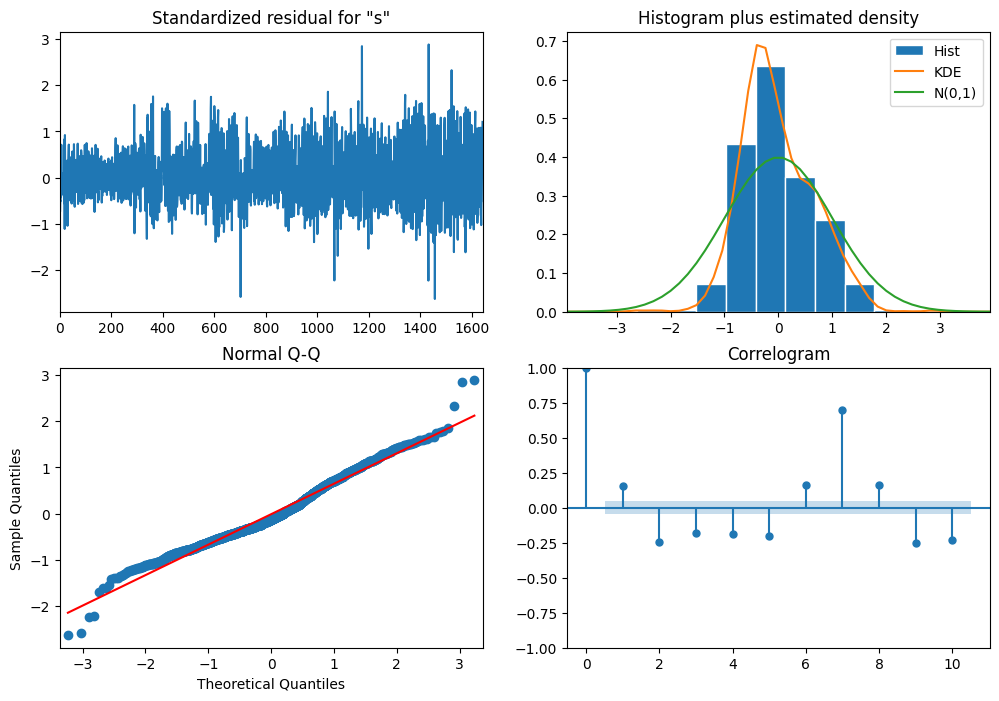

In [269]:
# Split the data into training and testing sets
train_size1 = int(len(tseries1)-16)
train_data1 = tseries1.iloc[:train_size1]
test_data1 = tseries1.iloc[train_size1:]

# Define the SARIMAX model with exogenous variables
order = (1, 1, 1)  
# Specify the order of the ARIMA component
seasonal_order = (1, 1, 0, 12)  
# Specify the order of the seasonal component
model = sm.tsa.SARIMAX(train_data1['sales'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
result = model.fit()

# Make predictions on the test set
forecast = result.get_forecast(steps=len(test_data1))

# Get the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print the predicted values and confidence intervals
print("Predicted Values:\n", predicted_values)
print("\nConfidence Intervals:\n", confidence_intervals)

# Evaluate the model (e.g., using Mean Squared Error)
mse = ((predicted_values - test_data1['sales']) ** 2).mean()
print("\nMean Squared Error:", mse)

# Plot the results
result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [270]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Date': test_data1['date'],
    'Actual Sales': test_data1['sales'],
    'Predicted Sales': predicted_values
})


# Plot using plotly.express
fig = px.line(plot_data, x='Date', y=['Actual Sales', 'Predicted Sales'],
              title='Actual vs Predicted Sales',
              labels={'value': 'Sales', 'variable': 'Type'},
              line_shape='linear', render_mode='svg')


# Show the plot
fig.show()

##### Model 2 - With all exogenous variables

In [271]:
tseries2 = tseries1

tseries2 = pd.merge(tseries2, oil, on='date', how='inner')
tseries2 = pd.merge(tseries2, nTransactions, on='date', how='inner')
tseries2 = pd.merge(tseries2, nTrain[['date', 'onpromotion', 'isPayday']].groupby('date').sum(), on='date', how='inner')

Predicted Values:
 1661    42339.779596
1662    45299.222523
1663    52388.552418
1664    43146.739329
1665    48145.796127
1666    56616.435978
1667    53156.895762
1668    39561.220575
1669    37765.797409
1670    47878.943440
1671    43988.893866
1672    51125.252063
1673    47277.100118
1674    48359.291543
1675    41695.309249
1676    39728.394608
Name: predicted_mean, dtype: float64

Confidence Intervals:
        lower sales   upper sales
1661  24043.700939  60635.858253
1662  23796.343396  66802.101651
1663  29447.502173  75329.602662
1664  19319.807992  66973.670666
1665  23646.218119  72645.374135
1666  31538.545914  81694.326041
1667  27547.411540  78766.379984
1668  13446.187782  65676.253368
1669  11161.797383  64369.797435
1670  20798.020481  74959.866400
1671  16440.791963  71536.995769
1672  23118.453174  79132.050952
1673  16443.070793  78111.129444
1674  15976.893347  80741.689738
1675   8222.012719  75168.605779
1676   5356.719499  74100.069716

Mean Squared Error: 42

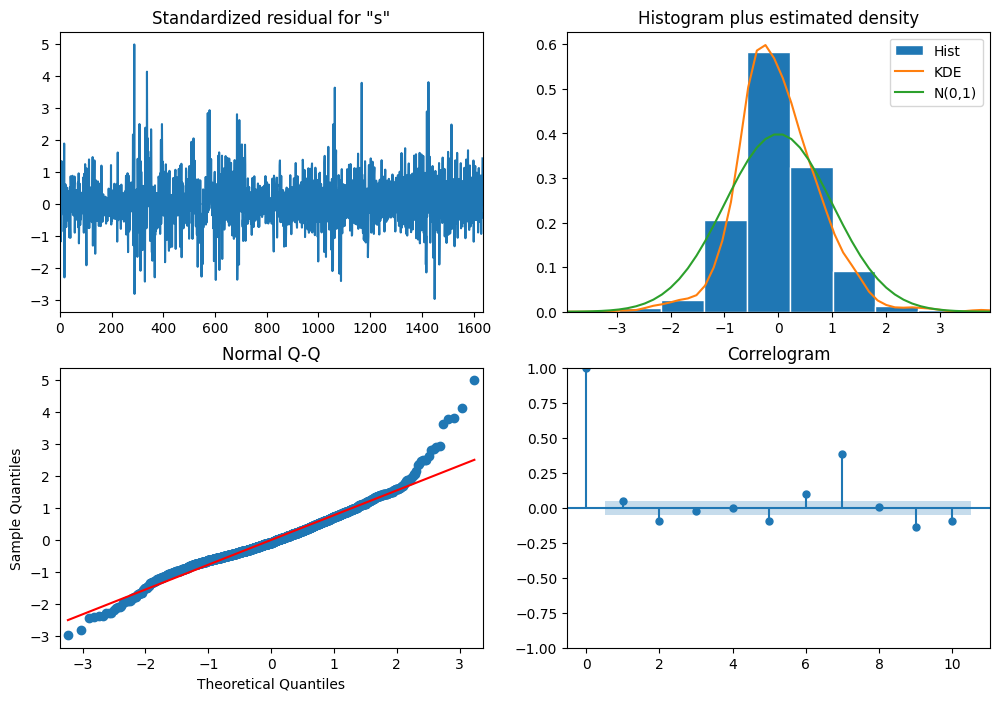

In [272]:
# Split the data into training and testing sets
train_size2 = int(len(tseries2)-16)
train_data2 = tseries2.iloc[:train_size2]
test_data2 = tseries2.iloc[train_size2:]

# Define the SARIMAX model with exogenous variables
order = (1, 1, 1)  
# Specify the order of the ARIMA component
seasonal_order = (1, 1, 0, 12)  
# Specify the order of the seasonal component
model = sm.tsa.SARIMAX(train_data2['sales'], exog=train_data2[['dcoilwtico_interpolated', 'isPayday', 'onpromotion', 'transactions']], order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
result = model.fit()

# Make predictions on the test set
forecast = result.get_forecast(steps=len(test_data2), exog=test_data2[['dcoilwtico_interpolated', 'isPayday', 'onpromotion', 'transactions']])

# Get the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print the predicted values and confidence intervals
print("Predicted Values:\n", predicted_values)
print("\nConfidence Intervals:\n", confidence_intervals)

# Evaluate the model (e.g., using Mean Squared Error)
mse = ((predicted_values - test_data2['sales']) ** 2).mean()
print("\nMean Squared Error:", mse)

# Plot the results
result.plot_diagnostics(figsize=(12, 8))
plt.show()


In [273]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Date': test_data2['date'],
    'Actual Sales': test_data2['sales'],
    'Predicted Sales': predicted_values
})


# Plot using plotly.express
fig = px.line(plot_data, x='Date', y=['Actual Sales', 'Predicted Sales'],
              title='Actual vs Predicted Sales',
              labels={'value': 'Sales', 'variable': 'Type'},
              line_shape='linear', render_mode='svg')


# Show the plot
fig.show()

##### Model 3 -  With all exogenous variables except for isPayday

Predicted Values:
 1661    42316.909046
1662    44769.902174
1663    52379.825310
1664    43114.859744
1665    48109.649719
1666    56583.024394
1667    53146.582589
1668    39525.444199
1669    38054.483545
1670    47871.168651
1671    43971.965061
1672    51112.234473
1673    47258.683020
1674    48354.013113
1675    41663.404029
1676    39167.852666
Name: predicted_mean, dtype: float64

Confidence Intervals:
        lower sales   upper sales
1661  24004.347464  60629.470629
1662  23225.885400  66313.918948
1663  29384.452251  75375.198368
1664  19227.166028  67002.553461
1665  23546.423034  72672.876403
1666  31440.481123  81725.567665
1667  27472.440381  78820.724798
1668  13346.268149  65704.620248
1669  11387.110573  64721.856517
1670  20727.755213  75014.582089
1671  16362.291217  71581.638906
1672  23044.779260  79179.689685
1673  16376.579054  78140.786987
1674  15923.586188  80784.440037
1675   8141.367027  75185.441030
1676   4747.552613  73588.152718

Mean Squared Error: 41

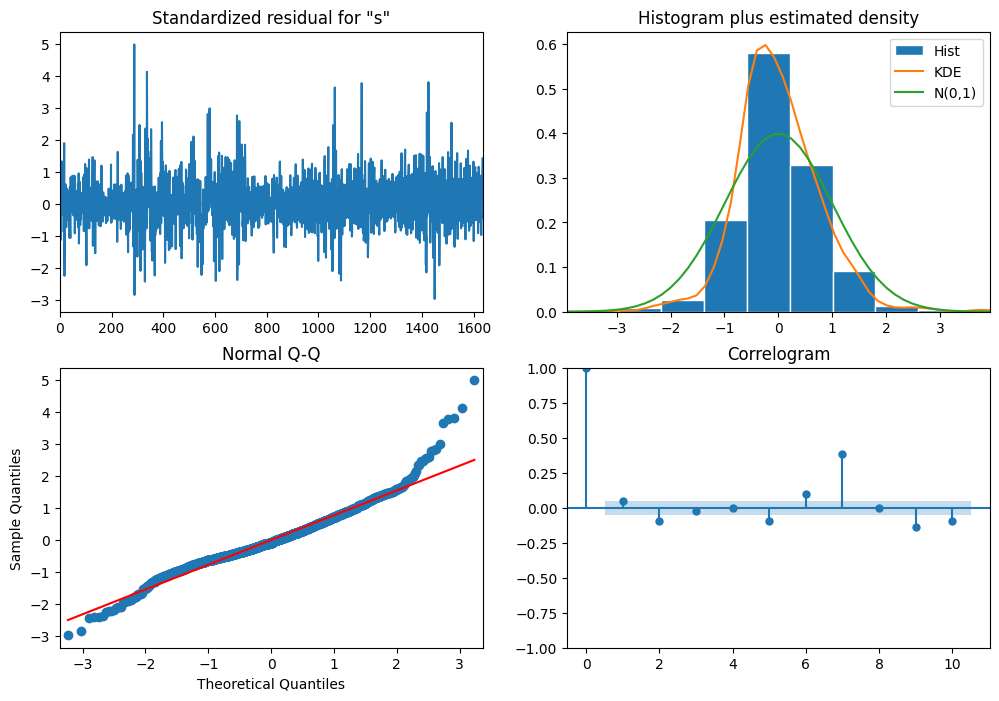

In [274]:
tseries3 = tseries1

tseries3 = pd.merge(tseries3, oil, on='date', how='inner')
tseries3 = pd.merge(tseries3, nTransactions, on='date', how='inner')
tseries3 = pd.merge(tseries3, nTrain[['date', 'onpromotion']].groupby('date').sum(), on='date', how='inner')

# Split the data into training and testing sets
train_size3 = int(len(tseries3)-16)
train_data3 = tseries3.iloc[:train_size3]
test_data3 = tseries3.iloc[train_size3:]

# Define the SARIMAX model with exogenous variables
order = (1, 1, 1)  
# Specify the order of the ARIMA component
seasonal_order = (1, 1, 0, 12)  
# Specify the order of the seasonal component
model = sm.tsa.SARIMAX(train_data3['sales'], exog=train_data3[['dcoilwtico_interpolated', 'onpromotion', 'transactions']], order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
result = model.fit()

# Make predictions on the test set
forecast = result.get_forecast(steps=len(test_data3), exog=test_data3[['dcoilwtico_interpolated', 'onpromotion', 'transactions']])

# Get the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print the predicted values and confidence intervals
print("Predicted Values:\n", predicted_values)
print("\nConfidence Intervals:\n", confidence_intervals)

# Evaluate the model (e.g., using Mean Squared Error)
mse = ((predicted_values - test_data3['sales']) ** 2).mean()
print("\nMean Squared Error:", mse)

# Plot the results
result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [275]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Date': test_data3['date'],
    'Actual Sales': test_data3['sales'],
    'Predicted Sales': predicted_values
})


# Plot using plotly.express
fig = px.line(plot_data, x='Date', y=['Actual Sales', 'Predicted Sales'],
              title='Actual vs Predicted Sales',
              labels={'value': 'Sales', 'variable': 'Type'},
              line_shape='linear', render_mode='svg')


# Show the plot
fig.show()

#### As observed in Model 2, where all exogenous variables are incorporated, the model yields a Mean Squared Error (MSE) of 42.1 million, significantly improved compared to Model 1, which lacks any exogenous variables and has an MSE of 187 million. However, upon excluding exogenous variables with low correlation to 'sales,' such as 'isPayday,' from the model, the predictions become slightly more accurate. Model 3 demonstrates this improvement, showing a reduced MSE of 41.6 million.

## Conclusion

#### SARIMAX is a powerful tool for time series forecasting, showcasing its effectiveness in relatively simple and stationary datasets and when coupled with relevant exogenous variables. However, in situations where data complexity surpasses the model's capabilities, the exploration of advanced machine learning models, such as Neural Networks, becomes imperative for achieving optimal precision and accuracy in predictions.